# DQN single asset : BTC

### Settings

In [1]:
import sys
external_pkgs_paths = [r".\external_pkgs\gym-0.18.3\gym-0.18.3"]
for path in external_pkgs_paths:
    if path not in sys.path:
        sys.path.insert(0, path) 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import (if not yet)

In [2]:
# !pip install datatable
# !pip install sympy
# !pip install pyyaml
# !pip install tqdm
# !pip install tensorflow

In [2]:
# import necessary modules
import ta
from functools import reduce
import pandas as pd
import gc
import pickle
import tensortrade as td
from pathlib import Path 
import datatable as dt

from tensortrade.exchanges import Exchange
from tensortrade.instruments import Instrument, CNY, USD
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, Module, DataFeed
from tensortrade.data import DataFeed, Module

# In[deploy network api]:
import tensorflow as tf
# In[deploy action schemes]:
from MoneyPositionScheme import * 
# In[deploy reward schemes]:
from RelativeReturnReward import RelativeReturnReward
# In[create environment]:
from tensortrade.environments import TradingEnvironment
# In[import agent]:
from tensortrade.agents import DQNAgent

## Get data

### 1. Get signals 

In [3]:
filepath = Path('../signals/csv/signals_crypto_fear&greed_index.csv')
df_index = dt.fread(filepath).to_pandas() 
df_index = df_index.set_index('date')
df_index = df_index.resample('H').ffill()
df_index.index = pd.to_datetime(df_index.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_index.tail(3))

filepath = Path('../signals/csv/signals_btc_strat.csv')
df_ta = dt.fread(filepath).to_pandas() 
df_ta = df_ta.set_index('date')
df_ta.index = pd.to_datetime(df_ta.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_ta.tail(3))

filepath = Path('../signals/csv/signals_glassnode.csv')
df_glassnode = dt.fread(filepath).to_pandas() 
df_glassnode = df_glassnode.set_index('date')
df_glassnode = df_glassnode.resample('H').ffill()
df_glassnode.index = pd.to_datetime(df_glassnode.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_glassnode.tail(3))

filepath = Path('../signals/csv/signals_wavelets.csv')
df_wavelet = dt.fread(filepath).to_pandas() 
df_wavelet = df_wavelet.set_index('date')
df_wavelet.index = pd.to_datetime(df_wavelet.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_wavelet.tail(3))

,fng_value,fng_classification
date,,
2022-04-05 22:00:00,53,0
2022-04-05 23:00:00,53,0
2022-04-06 00:00:00,48,0


,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond
date,,,,,,
2022-04-07 00:52:00,True,True,0,-1,False,False
2022-04-07 00:54:00,True,True,0,-1,False,False
2022-04-07 00:55:00,True,True,0,-1,False,False


,glassnode_f1,glassnode_f2,glassnode_f3,glassnode_f4,glassnode_f5
date,,,,,
2022-04-04 22:00:00,6.099674,6.561470,4.737371,0.0,14.345889
2022-04-04 23:00:00,6.099674,6.561470,4.737371,0.0,14.345889
2022-04-05 00:00:00,6.792104,2.989913,4.855690,0.0,10.875053


,wavelet_smoothing,wavelet_clf
date,,
2022-04-07 00:52:00,41796.938114,True
2022-04-07 00:54:00,41789.281319,True
2022-04-07 00:55:00,41771.958831,True


### 2. Get BTC close price

In [4]:
filepath = Path('../data/csv/crypto_market_data.csv')
# Get crypto data
df_crypto = dt.fread(filepath).to_pandas() 
df_crypto = df_crypto.T.set_index([0, 1]).T
df_crypto = df_crypto.set_index('')
df_crypto = df_crypto.astype(float)
df_crypto.index.names = ['date']
# Get the daily return (on the close price of the BTC)
df_close = df_crypto.T.swaplevel(0, 1).T['Close']['BTC-USD']
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close[df_close.index.hour == 23]
df_close.index = df_close.index.date
df_close.index = pd.to_datetime(df_close.index).strftime('%Y-%m-%d %H:%M:%S')
df_close = pd.DataFrame(df_close, index=df_close.index, columns=['BTC-USD'])
display(df_close.tail(3))

,BTC-USD
2022-04-04 00:00:00,46615.023438
2022-04-05 00:00:00,45553.027344
2022-04-06 00:00:00,43193.953125


## Get data ready for RL model

In [5]:
df = df_wavelet.join(df_index).join(df_glassnode).join(df_ta).join(df_close).dropna(axis=0)*1
df.index = pd.to_datetime(df.index)

In [6]:
display(df.shape, df.index.min(), df.index.max())
df.head(3)

(452, 16)

Timestamp('2020-04-15 00:00:00')

Timestamp('2022-04-05 00:00:00')

,wavelet_smoothing,wavelet_clf,fng_value,fng_classification,glassnode_f1,glassnode_f2,glassnode_f3,glassnode_f4,glassnode_f5,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond,BTC-USD
date,,,,,,,,,,,,,,,,
2020-04-15,7108.619077,0,18.0,-2.0,4.165846,9.186098,10.781787,0.0,17.062986,0,0,0,-1,0,0,6642.109863
2020-04-23,7233.598506,0,19.0,-2.0,3.959871,8.574373,10.370236,0.0,17.690790,1,1,0,0,0,0,7429.724609
2020-04-25,7474.446751,1,24.0,-2.0,4.645470,10.297437,9.963661,0.0,14.971171,0,0,0,-1,0,0,7554.173828


#### Split data

In [7]:
train_data = df[df.index < "20210630"]
test_data = df[df.index >= "20210630"]

## Reinforcement Learning Setup

### 1. Create Exchanges

In [8]:
BTC = Instrument('BTC', 2, 'Bintcoin')

config = {
    "base_instrument": USD,
    "instruments": [BTC]
}

with td.TradingContext(**config):
    exchange_name = 'train_data_exchange'
    train_data_exchange = Exchange(exchange_name, service=execute_order, timestamps=train_data.index.tolist())(
        Stream("-".join([BTC.symbol, USD.symbol]), list(train_data['BTC-USD']))
    )
train_data_exchange.build()
print(train_data_exchange._prices)

with td.TradingContext(**config):
    exchange_name = 'test_data_exchange'
    test_data_exchange = Exchange(exchange_name, service=execute_order, timestamps=test_data.index.tolist())(
        Stream("-".join([BTC.symbol, USD.symbol]), list(test_data['BTC-USD']))
    )
test_data_exchange.build()
print(test_data_exchange._prices)

{'BTC/USD': <Node: name=BTC-USD, type=forward>}
{'BTC/USD': <Node: name=BTC-USD, type=forward>}


### 2. Create the data feed

In [9]:
def create_feed(raw_data, module_name, colprefix="BTC", drop_raw=False, feature_list=None):
    
    feature_data = raw_data.copy(deep=True)
    colprefix = colprefix + "_"

    if drop_raw:
        num_raw_cols = feature_data.shape[1]
        feature_data = feature_data.iloc[:, num_raw_cols:]

    if feature_list is None:
        feature_list = feature_data.columns.tolist()
    else:
        feature_list = [colprefix + x for x in feature_list]

    with Module(module_name) as ns:
        for col in feature_list:
            ns = ns(Stream(col, list(feature_data[col])))
    feed = DataFeed([ns])
    return feed

In [10]:
#wavelet_feed = create_feed(raw_data=df_wavelet, module_name="wavelet", colprefix="BTC", drop_raw=False, feature_list=None)
#index_feed = create_feed(raw_data=df_index, module_name="index", colprefix="BTC", drop_raw=False, feature_list=None)
#glassnode_feed = create_feed(raw_data=df_glassnode, module_name="glassnode", colprefix="BTC", drop_raw=False, feature_list=None)
#ta_feed = create_feed(raw_data=df_ta, module_name="ta", colprefix="BTC", drop_raw=False, feature_list=None)

#train_feed = wavelet_feed + index_feed + glassnode_feed + ta_feed

In [11]:
train_close = train_data['BTC-USD']
test_close = test_data['BTC-USD']

train_data = train_data.drop(columns=['BTC-USD'])
test_data = test_data.drop(columns=['BTC-USD'])

In [12]:
train_feed = create_feed(raw_data=train_data, module_name="train", colprefix="BTC", drop_raw=False, feature_list=None)
test_feed = create_feed(raw_data=test_data, module_name="test", colprefix="BTC", drop_raw=False, feature_list=None)

In [13]:
train_feed.next()

{'train:/wavelet_smoothing': 7108.619077124501,
 'train:/wavelet_clf': 0,
 'train:/fng_value': 18.0,
 'train:/fng_classification': -2.0,
 'train:/glassnode_f1': 4.165846,
 'train:/glassnode_f2': 9.186098,
 'train:/glassnode_f3': 10.781787,
 'train:/glassnode_f4': 0.0,
 'train:/glassnode_f5': 17.062986,
 'train:/condition_BBW': 0,
 'train:/condition_Vol': 0,
 'train:/strat_BB': 0,
 'train:/strat_MACD': -1,
 'train:/strat_HH_LL': 0,
 'train:/combine_strat_cond': 0}

In [14]:
test_feed.next()

{'test:/wavelet_smoothing': 35421.38633832649,
 'test:/wavelet_clf': 0,
 'test:/fng_value': 29.0,
 'test:/fng_classification': -1.0,
 'test:/glassnode_f1': 6.524730000000001,
 'test:/glassnode_f2': 11.788288,
 'test:/glassnode_f3': 4.3401647,
 'test:/glassnode_f4': 0.0,
 'test:/glassnode_f5': 10.2067,
 'test:/condition_BBW': 1,
 'test:/condition_Vol': 0,
 'test:/strat_BB': -1,
 'test:/strat_MACD': -1,
 'test:/strat_HH_LL': 0,
 'test:/combine_strat_cond': 0}

In [15]:
print(f'# signals : {len(train_feed.next())}')

# signals : 15


In [16]:
print(f'# signals : {len(test_feed.next())}')

# signals : 15


### 3. Create portfolio

In [17]:
with td.TradingContext(**config):
    train_portfolio = Portfolio(USD, [
        Wallet(train_data_exchange, 100000 * USD),
        Wallet(train_data_exchange, 0 * BTC)
    ])

with td.TradingContext(**config):
    test_portfolio = Portfolio(USD, [
        Wallet(test_data_exchange, 100000 * USD),
        Wallet(test_data_exchange, 0 * BTC)
    ])

### 4. Create Environments for RL

In [18]:
train_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
test_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
relativeReward = RelativeReturnReward()
window_size = 10
max_episode_timesteps = 40
stochastic_reset = True

with td.TradingContext(**config):
    train_env = TradingEnvironment(portfolio=train_portfolio,
                                   reward_scheme=relativeReward,
                                   action_scheme=train_Action,
                                   max_episode_timesteps=max_episode_timesteps,
                                   external_feed=train_feed,
                                   window_size=window_size,
                                   observe_internal_feed=False,
                                   on_execute_verbose=False,
                                   stochastic_reset=stochastic_reset,
                                   clock_map=train_data.index.tolist())

    test_env = TradingEnvironment(portfolio=test_portfolio,
                                  reward_scheme=relativeReward,
                                  action_scheme=test_Action,
                                  max_episode_timesteps=max_episode_timesteps,
                                  external_feed=test_feed,
                                  window_size=window_size,
                                  observe_internal_feed=False,
                                  on_execute_verbose=False,
                                  stochastic_reset=stochastic_reset,
                                  clock_map=test_data.index.tolist())

# env.reset() 

### 4. Config network structure

In [19]:
# tf.reset_default_graph()
with tf.device(
        '/CPU:0'):  # tf2.3.will raise error if there are other tf GPU processes running on this device(maybe Chrome)
    network = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=train_env.observation_space.shape),
        tf.keras.layers.Conv1D(filters=5, kernel_size=5, padding="valid", activation="tanh"),  # horizontal filter
        # tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding="valid", activation="tanh"),
        # tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(len(train_env.action_space), activation="relu")
    ])


In [20]:
train_env.observation_space.shape

(10, 15)

In [21]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 5)              380       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 4)              104       
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 11)                99        
                                                                 
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


In [22]:
agent_spec = {
    'discount_factor': 0.5,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'eps_start': 1,
    'eps_end': 0.05,
    'eps_decay_steps': 20,
    'update_target_every': 100,
    'memory_capacity': 10000,
    "ini_steps": 512,
    "max_episode_timesteps": train_env.max_episode_timesteps}
save_path = r'.\models\train'
step_verbose = False
episode_verbose = False
n_episodes = 50
save_every = 5
evaluate_every_n_episode = 5
save_episodic_performance = False

## Train-Test model

### 1. Baseline: buy and hold

<AxesSubplot:xlabel='date'>

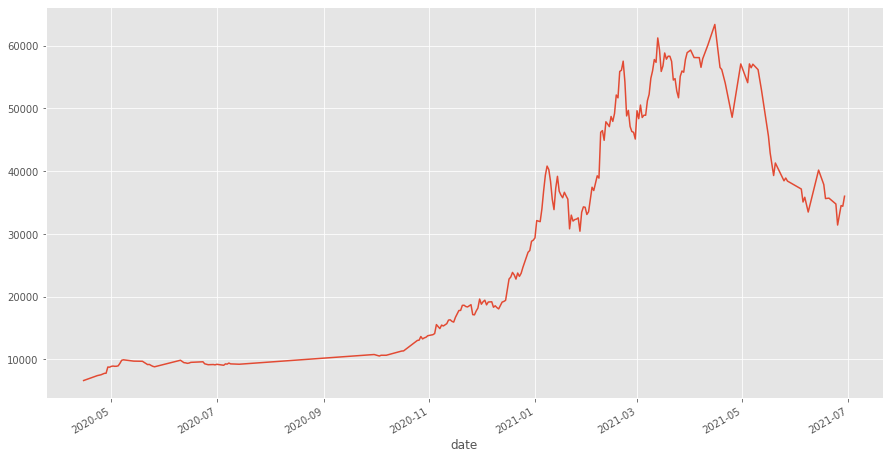

In [23]:
train_close.plot(figsize=(15,8))

### 2. Train RL agent

In [ ]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)
    myAgent.train(n_episodes=n_episodes,
                  save_every=save_every,
                  save_path=save_path,
                  step_verbose=step_verbose,
                  episode_verbose=episode_verbose,
                  evaluate_every_n_episode=evaluate_every_n_episode,
                  save_episodic_performance=save_episodic_performance,
                  **agent_spec)

### 3. Restore RL agent

In [25]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)

In [ ]:
# the last number for the .h5 is the number of epsiode trained (you need to make sure the following path exists!!)
myAgent.restore("./models/train/policy_network__a13bf913-f3f2-4077-8620-bda9693b0899__35.h5")  

### 4. Test over different data sets (environments)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.76it/s]


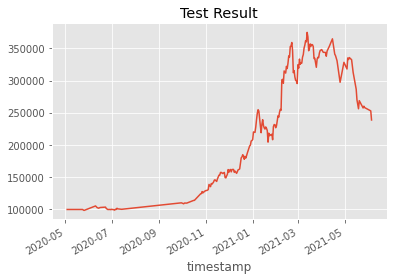

Annual Sharpe: -2.174828193783415
Maximum drop down: 1.4265873047177728
Cumulative return(single-rate): -0.9957254669616022
Cumulative return(compound-rate) : 1.3880236908203134


In [27]:
with tf.device('/CPU:0'):
    myAgent.env = train_env  # set the environment you want to test
    myAgent.test(start_step = 10, n_steps=200) # make sure you won't exceed the maximum length of the data feed in the envirnoment

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.25it/s]


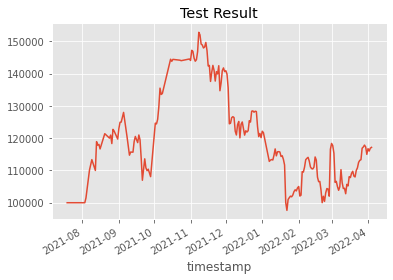

Annual Sharpe: -0.64103356978805
Maximum drop down: 0.45997316259155063
Cumulative return(single-rate): -0.2429742800156456
Cumulative return(compound-rate) : 0.17135077929687514


In [28]:
with tf.device('/CPU:0'):
    myAgent.env = test_env  # set the environment you want to test
    myAgent.test(start_step = 10, n_steps=200)  # make sure you won't exceed the maximum length of the data feed in the envirnoment

### 5. Compare with baseline performance

In [27]:
def max_dropdown(series):
    _acc = series.cumsum().tolist()
    _max = -np.inf
    max_dd = 0

    for _val in _acc:
        _max = max(_max, _val)
        max_dd = max(max_dd, _max - _val)
    return max_dd

import matplotlib.pyplot as plt
def get_baseline_metrics(price):
    
    price.plot(figsize=(15,8), title="BTC(test set)")
    plt.show()
    ret = price.diff(-1) / price
    sharpe = np.sqrt(252) * ret.mean() / ret.std()
    mdd = max_dropdown(ret)
    cum_ret = ret.sum()

    print("Annual Sharpe: {}".format(sharpe))
    print("Maximum drop down: {}".format(mdd))
    print("Cumulative return(single-rate): {}".format(cum_ret))
    print("Cumulative return(compound-rate) : {}".format(price.iloc[-1]/price.iloc[0] - 1))

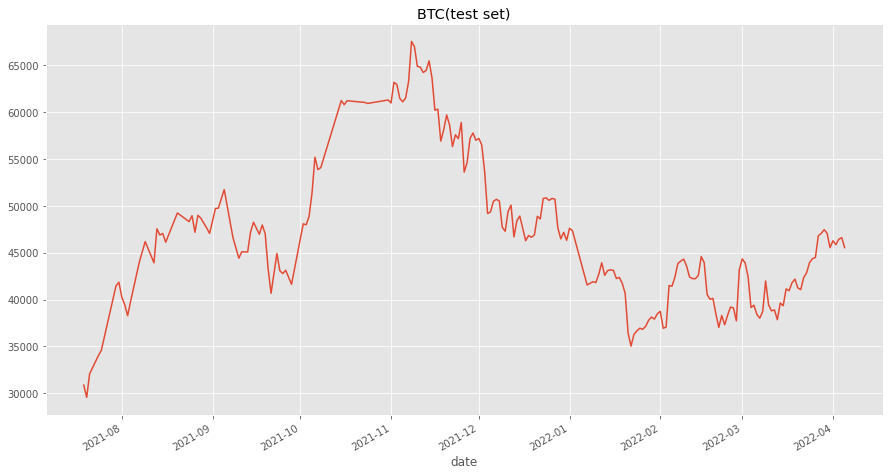

Annual Sharpe: -1.0259611779522402
Maximum drop down: 0.9165702181607617
Cumulative return(single-rate): -0.5698038022078159
Cumulative return(compound-rate) : 0.4758713077351915


In [28]:
price = test_close.iloc[10:]
get_baseline_metrics(price)

### 6. Show the action history while testing

<AxesSubplot:title={'center':'Cash Held'}, xlabel='timestamp'>

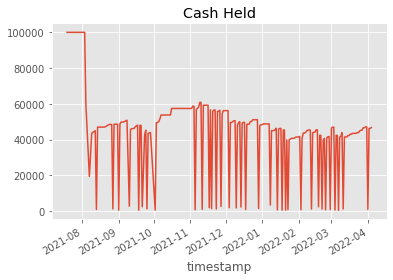

In [40]:
test_env.portfolio.performance["test_data_exchange:/USD:/free"].iloc[10:].plot(title="Cash Held")

<AxesSubplot:title={'center':'cash held'}, xlabel='timestamp'>

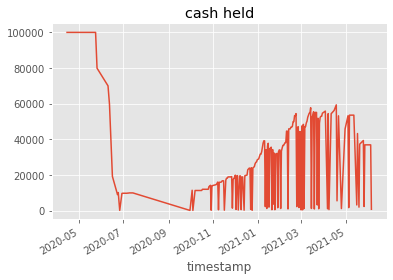

In [44]:
train_env.portfolio.performance["train_data_exchange:/USD:/free"].plot(title="cash held")